In [2]:
import pandas as pd
import numpy as np

In [3]:
#read data
data = pd.read_csv('./custdata.tsv', sep = '\t')

In [4]:
data.head()

,custid,sex,is.employed,income,marital.stat,health.ins,housing.type,recent.move,num.vehicles,age,state.of.res
0,2068,F,NaN,11300,Married,True,Homeowner free and clear,False,2.0,49,Michigan
1,2848,M,True,4500,Never Married,False,Rented,True,3.0,22,Georgia
2,5641,M,True,20000,Never Married,False,Occupied with no rent,False,0.0,22,New Mexico
3,6369,F,True,12000,Never Married,True,Rented,True,1.0,31,Florida
4,8322,F,True,180000,Never Married,True,Homeowner with mortgage/loan,False,1.0,40,New York


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910 entries, 0 to 909
Data columns (total 11 columns):
custid          910 non-null int64
sex             910 non-null object
is.employed     655 non-null object
income          910 non-null int64
marital.stat    910 non-null object
health.ins      910 non-null bool
housing.type    879 non-null object
recent.move     879 non-null object
num.vehicles    879 non-null float64
age             910 non-null int64
state.of.res    910 non-null object
dtypes: bool(1), float64(1), int64(3), object(6)
memory usage: 72.1+ KB


# Missing Visualization

In [6]:
import missingno as miss
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

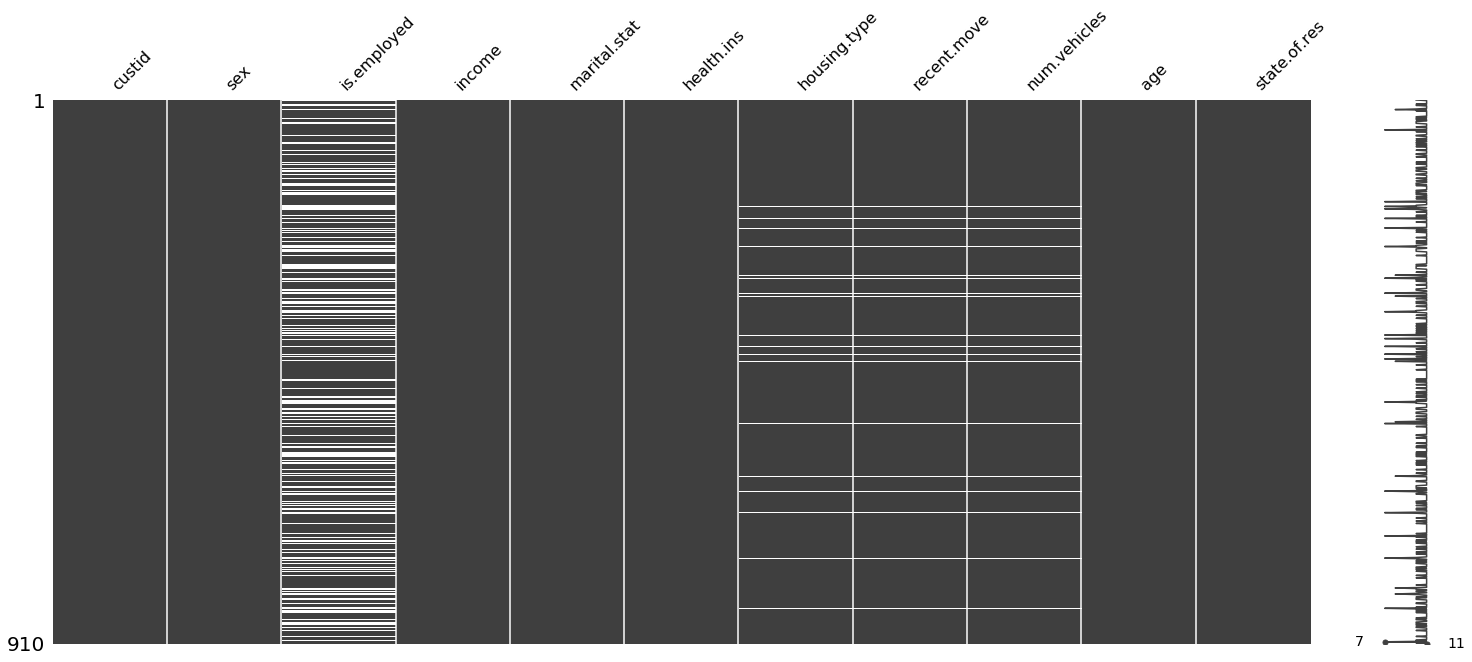

In [7]:
miss.matrix(data)

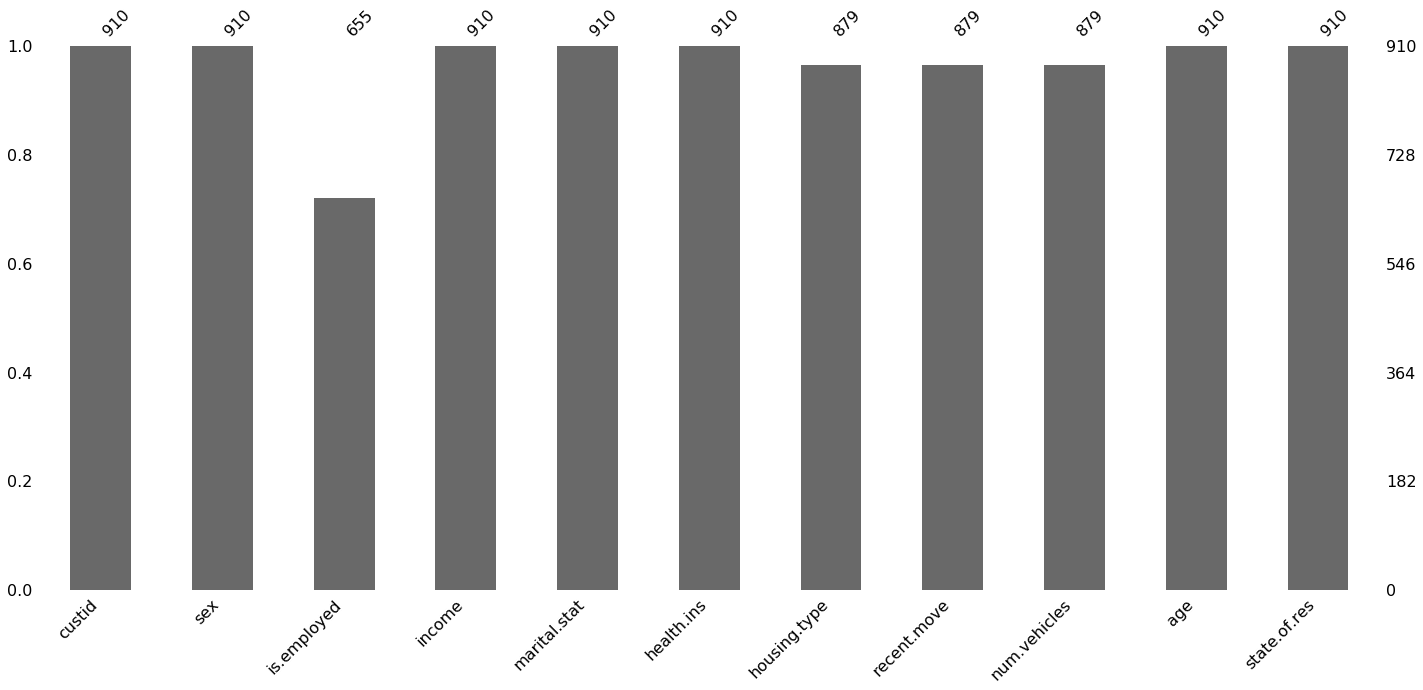

In [8]:
data.isnull().sum(axis=0)
miss.bar(data);

In [14]:
# Drop na
cust_clean = data.dropna(subset=['is.employed'], how='all') # drop if na in specific column

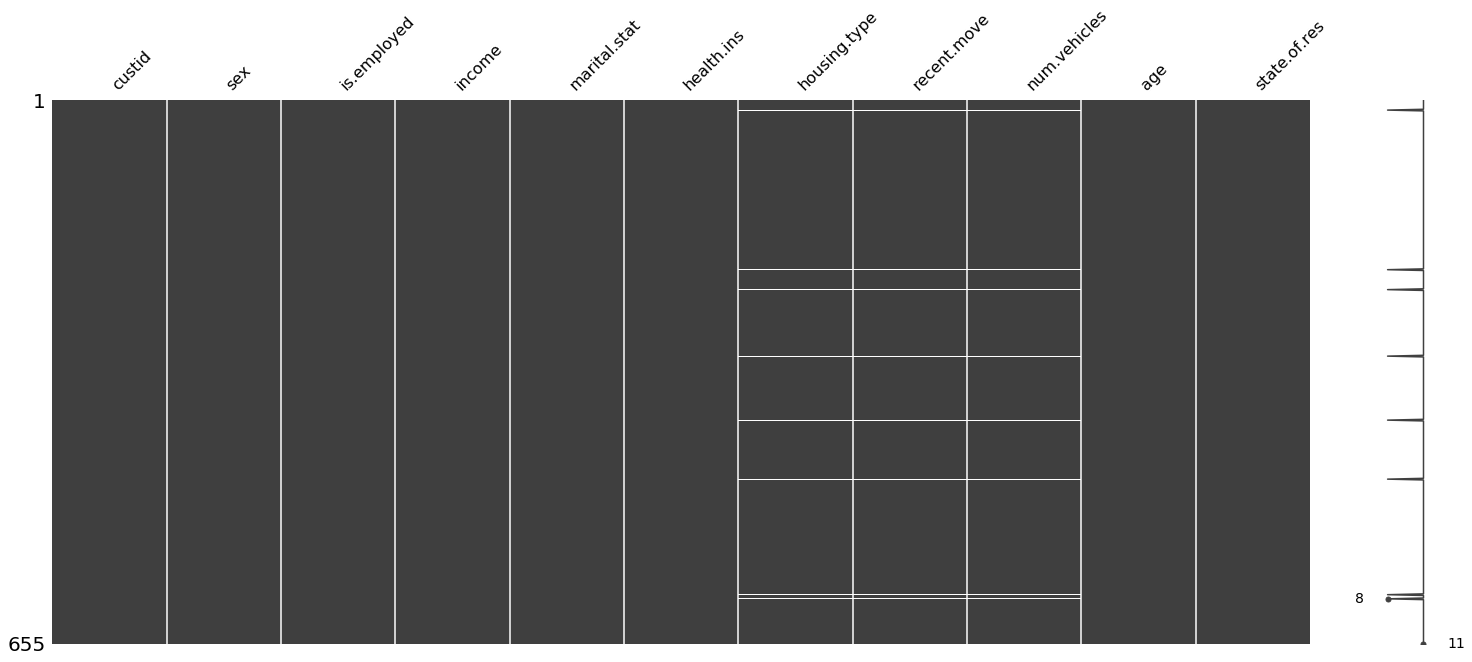

In [16]:
miss.matrix(cust_clean);

# Impute strategy - using SKLEARN Imputer

**The imputation strategy.**
- If “mean”, then replace missing values using the mean along the axis.
- If “median”, then replace missing values using the median along the axis.
- If “most_frequent”, then replace missing using the most frequent value along the axis.


In [9]:
def skImpute(data, col2Impute, strategy='most_frequent'):
    from sklearn.preprocessing import Imputer


    imp = Imputer(missing_values='NaN',
                strategy=strategy)

    imp_col = imp.fit_transform(data[['is.employed']])
    return imp_col

imp_col = skImpute
data['is.employed_IS2'] = imp_col == 1

data[["is.employed", "is.employed_IS2"]][0:5]


,is.employed,is.employed_IS2
0,NaN,False
1,True,False
2,True,False
3,True,False
4,True,False


# Custom Impute based on business rule - example

In [10]:
import math

def impute_is_employed( employed, age, income ):

  if not math.isnan( employed ):
      return employed
  else:
      if age > 60:
          return False
      elif income > 2000:
          return True
      else:
          return False
data["is.employed_IS3"] = data.apply( lambda rec:
                                           impute_is_employed( rec["is.employed"],
                                                              rec.age,
                                                              rec.income ),
                                           axis = 1 )
data[["age", "income", "is.employed", "is.employed_IS3"]].head( 5 )

,age,income,is.employed,is.employed_IS3
0,49,11300,NaN,True
1,22,4500,True,True
2,22,20000,True,True
3,31,12000,True,True
4,40,180000,True,True


# Imputation using FancyImpute

**Algorithms **

SimpleFill: Replaces missing entries with the mean or median of each column.

KNN: Nearest neighbor imputations which weights samples using the mean squared difference on features for which two rows both have observed data.

SoftImpute: Matrix completion by iterative soft thresholding of SVD decompositions. Inspired by the softImpute package for R, which is based on Spectral Regularization Algorithms for Learning Large Incomplete Matrices by Mazumder et. al.

IterativeSVD: Matrix completion by iterative low-rank SVD decomposition. Should be similar to SVDimpute from Missing value estimation methods for DNA microarrays by Troyanskaya et. al.

MICE: Reimplementation of Multiple Imputation by Chained Equations.

MatrixFactorization: Direct factorization of the incomplete matrix into low-rank U and V, with an L1 sparsity penalty on the elements of U and an L2 penalty on the elements of V. Solved by gradient descent.

NuclearNormMinimization: Simple implementation of Exact Matrix Completion via Convex Optimization by Emmanuel Candes and Benjamin Recht using cvxpy. Too slow for large matrices.

BiScaler: Iterative estimation of row/column means and standard deviations to get doubly normalized matrix. Not guaranteed to converge but works well in practice. Taken from Matrix Completion and Low-Rank SVD via Fast Alternating Least Squares.

In [15]:
from fancyimpute import KNN

def fancyImpute(data, cols = ['age', 'income', 'num.vehicles']):
    x = pd.DataFrame(KNN(k=30).complete(data[cols]))
    x.columns = cols
    return x

X_filled_knn = fancyImpute(data)

data['numvehicles_IS2'] = np.round(X_filled_knn['num.vehicles'], 0)
data[data['num.vehicles'].isnull()][['age',
                                           'income',
                                           'num.vehicles',
                                           'numvehicles_IS2']][0:10]

Imputing row 1/910 with 0 missing, elapsed time: 0.117
Imputing row 101/910 with 0 missing, elapsed time: 0.118
Imputing row 201/910 with 0 missing, elapsed time: 0.118
Imputing row 301/910 with 0 missing, elapsed time: 0.119
Imputing row 401/910 with 0 missing, elapsed time: 0.119
Imputing row 501/910 with 0 missing, elapsed time: 0.120
Imputing row 601/910 with 0 missing, elapsed time: 0.120
Imputing row 701/910 with 0 missing, elapsed time: 0.120
Imputing row 801/910 with 0 missing, elapsed time: 0.121
Imputing row 901/910 with 0 missing, elapsed time: 0.121


,age,income,num.vehicles,numvehicles_IS2
16,28,30000,NaN,2.0
50,28,100,NaN,3.0
170,93,10100,NaN,1.0
178,49,440,NaN,1.0
182,31,200,NaN,2.0
198,73,11200,NaN,2.0
214,93,3000,NaN,2.0
245,55,24800,NaN,3.0
293,18,80,NaN,3.0
298,68,13300,NaN,2.0


### In R use caret for Imputation